# Init

In [7]:
import cv2
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
import seaborn as sns
import cv2
from skimage.transform import warp, AffineTransform

In [8]:
sns.set(style='dark')
plt.rcParams['figure.constrained_layout.use'] = True
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

# Task 1: complete implementation of the `warp_inv` so that it supports linear interpolation by passing `interp='linear'`

In [9]:
import numpy as np

def warp_inv(img: np.ndarray, A: np.ndarray, interp: str = 'nearest') -> np.ndarray:
    height, width = img.shape[:2]
    
    # get image corners and transform them
    X = np.array([0., width, width, 0.])
    Y = np.array([0., 0., height, height])
    XY = np.vstack((X, Y, np.ones(4)))
    XY_ = np.dot(A, XY)
    XY_ /= XY_[-1, :]
    ox_, oy_ =  XY_[0, :].min(),  XY_[1, :].min()
    
    # calculate the new size
    width_ = int(XY_[0, :].max() - XY_[0, :].min())
    height_ = int(XY_[1, :].max() - XY_[1, :].min())
    img_ = np.zeros((height_, width_), dtype=img.dtype)
    
    # invert transformation
    A_inv = np.linalg.inv(A)

    # helper function to safely get a value gray[y, x]
    def src_img_at(x, y):
        if 0 <= x < width and 0 <= y < height:
            return img[y, x]
        else:
            return 0
    
    # the main transformation loop
    for y_ in range(height_):
        for x_ in range(width_):
            # inverse transform
            x, y, z = np.dot(A_inv, [x_ + ox_, y_ + oy_, 1.])
            
            # normalize homogeneous coordinates
            x /= z
            y /= z

            # interpolation
            if interp == 'nearest':
                x = int(0.5 + x)
                y = int(0.5 + y)    
                img_[y_, x_] = src_img_at(x, y)
            
            elif interp == 'linear':
                x_int = int(x)
                y_int = int(y)
                
                x_frac = x - x_int
                y_frac = y - y_int
                
                x_int = max(0, min(width - 2, x_int))
                y_int = max(0, min(height - 2, y_int))
                
                # Bilinear interpolation
                img_[y_, x_] = (
                    (1 - x_frac) * (1 - y_frac) * src_img_at(x_int, y_int) +
                    x_frac * (1 - y_frac) * src_img_at(x_int + 1, y_int) +
                    (1 - x_frac) * y_frac * src_img_at(x_int, y_int + 1) +
                    x_frac * y_frac * src_img_at(x_int + 1, y_int + 1)
                )
            
            else:
                raise ValueError(interp)
    
    return img_

img = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=np.uint8)
A = np.array([[2, 0, 0], [0, 2, 0], [0, 0, 1]])
result = warp_inv(img, A, interp='linear')
print(result)


[[1 1 2 2 2 2]
 [2 3 3 4 3 4]
 [4 4 5 5 5 5]
 [5 6 6 7 6 7]
 [4 4 5 5 5 5]
 [5 6 6 7 6 7]]


In [10]:
rgb = cv2.imread('./robot.bmp')[..., ::-1]
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

A_hom = np.array([
    [ 0.9, -0.3, 50.],
    [-0.5,  1.0, 30.],
    [-0.002, -0.0015, 1]
])

gray_hom_nn = warp_inv(gray, A_hom, interp='nearest')
gray_hom_lin = warp_inv(gray, A_hom, interp='linear')

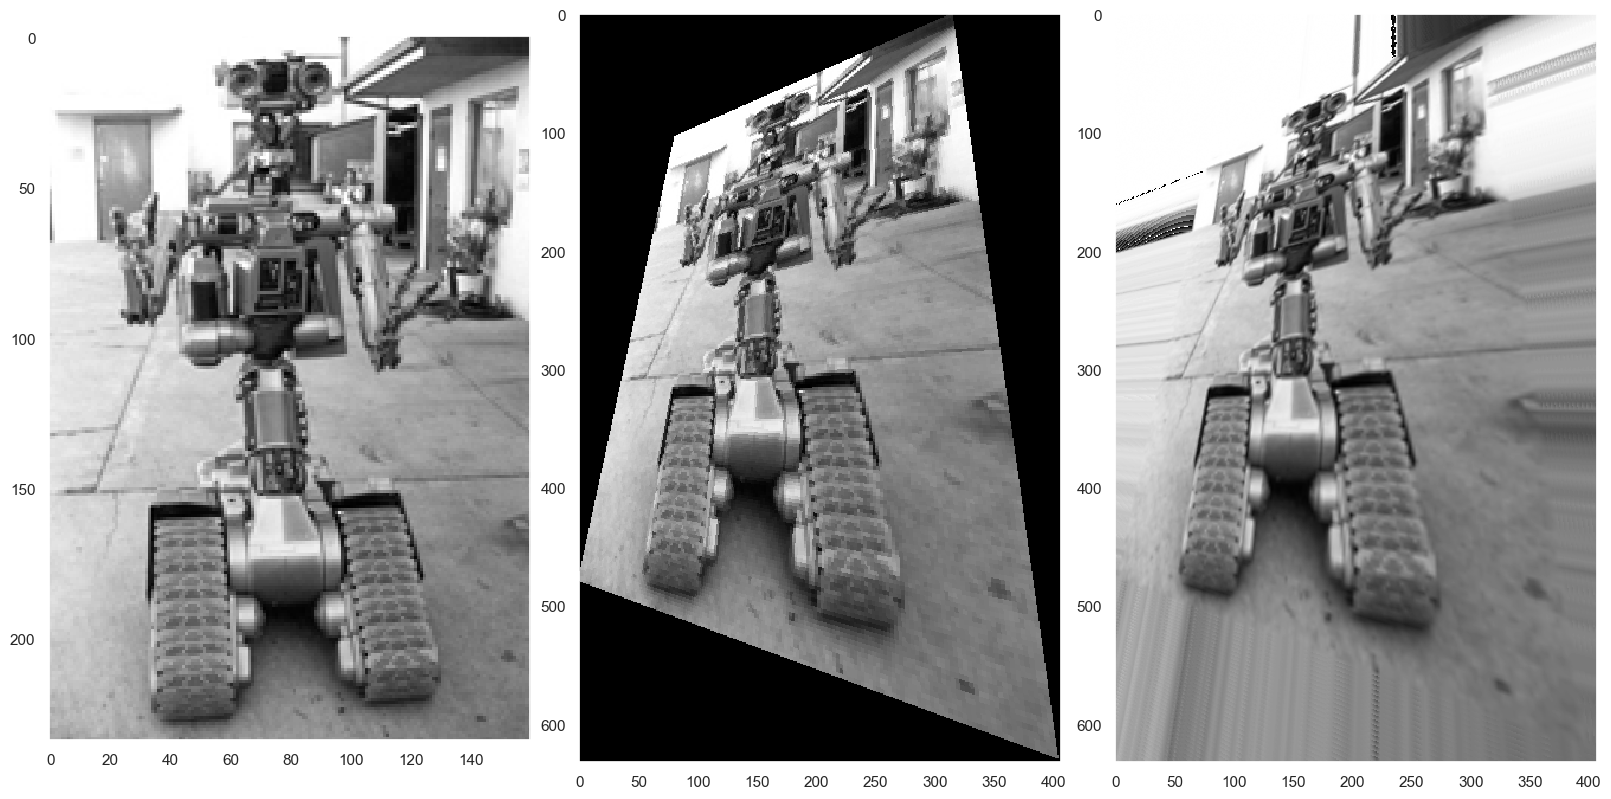

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 16))
axes[0].imshow(gray, cmap='gray', vmin=0., vmax=255, interpolation='none')
axes[1].imshow(gray_hom_nn, cmap='gray', vmin=0, vmax=255, interpolation='none');
axes[2].imshow(gray_hom_lin, cmap='gray', vmin=0, vmax=255, interpolation='none');

# Task 2: rotation around center of the image instead of origin=(0, 0)

Create the matrix `A_rot` (matrix $\bold{A}$ of shape $3 \times 3$) such that the input image is rotated around its center instead of the top-left point. It must work for arbitray angle $\phi$.

*Hint*: You need to set the translation offsets $t_x$ and $t_y$ to correct values.

In [12]:
rgb = cv2.imread('./robot.bmp')[..., ::-1]

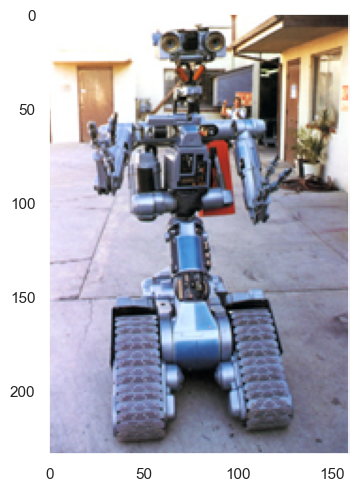

In [13]:
plt.imshow(rgb);

In [14]:
# Angle of rotation
phi_rot = 60. # degrees

# Get the image dimensions
height, width = rgb.shape[:2]

# Calculate the center of the image
center_x, center_y = width // 2, height // 2

# Calculate the new image dimensions
new_width = int(np.round(width * np.abs(np.cos(np.radians(phi_rot))) + height * np.abs(np.sin(np.radians(phi_rot)))))
new_height = int(np.round(height * np.abs(np.cos(np.radians(phi_rot))) + width * np.abs(np.sin(np.radians(phi_rot)))))

# Calculate the rotation matrix around the center
A_rot = cv2.getRotationMatrix2D((center_x, center_y), phi_rot, 1.0)

# Update the rotation matrix to take into account translation
A_rot[0, 2] += (new_width / 2) - center_x
A_rot[1, 2] += (new_height / 2) - center_y

# Perform the affine warp with the new dimensions
rgb_rot = cv2.warpAffine(rgb, A_rot, (new_width, new_height))


# Task3: Transformation estimation in OpenCV

- Re-implement the example of the region of interest (ROI) extraction using transformation estimation that's in the notebook `geom-transform.ipynb` **using OpenCV**.
- Apply the method to extract the Sudoku grid from the image `data/sudoku-alt3.jpg`.
- Mark the corner points in the image manually.
- The resulting ROI should be a square image with the side length divisible by 9.

*Hint*: you'll probably need the functions `findHomography` and `warpPerspective`.

In [15]:
rgb = cv2.imread('./sudoku-alt3.jpg')[..., ::-1]

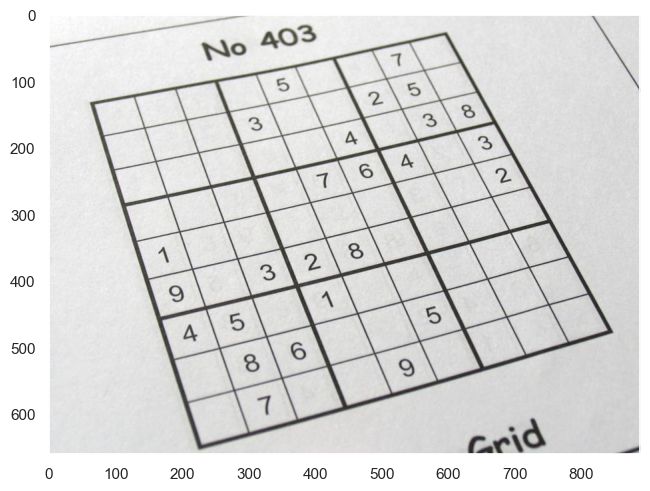

In [16]:
plt.imshow(rgb);

In [17]:
# Manually mark the corner points of the Sudoku grid
src_xy = np.array([[60, 130], [600, 25], [225, 660], [850, 480]], dtype=np.float32)

# Define the size of the resulting square ROI
roi_size = 450

# Destination points for the square ROI
dst_xy = np.array([[0, 0], [roi_size - 1, 0], [0, roi_size - 1], [roi_size - 1, roi_size - 1]], dtype=np.float32)

# Calculate the transformation matrix
transformation_matrix, _ = cv2.findHomography(src_xy, dst_xy)

# Apply perspective transformation to extract the ROI
roi = cv2.warpPerspective(rgb, transformation_matrix, (roi_size, roi_size))



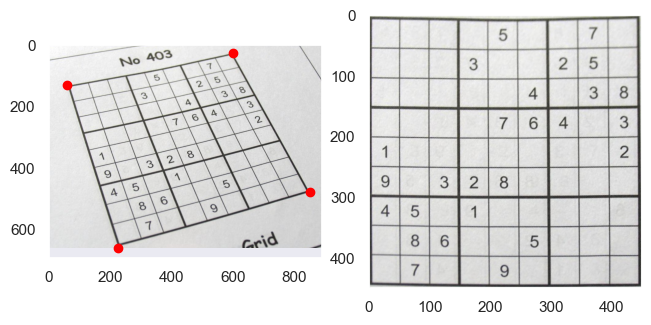

In [18]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb)
axes[0].plot(src_xy[:, 0], src_xy[:, 1], 'o', color=(1, 0, 0));
axes[1].imshow(roi);